In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pyodbc

In [3]:
# Step 1: ETL Process
# Extract the data from the SQL database
def extract_data():
    print("Extracting data from SQL database...")

    # Connection to the SQL Server
    connection = pyodbc.connect(
        "DRIVER={ODBC Driver 17 for SQL Server};"
        "SERVER=DESKTOP-27BM9SI;"  # Your server name here
        "DATABASE=DB;"  # Your database name here
        "Trusted_Connection=yes;"
        "TrustServerCertificate=yes;"
    )

    # Query to extract data
    query = "SELECT * FROM road_accidents"
    
    # Read data from SQL into a pandas DataFrame
    df = pd.read_sql(query, connection)

    # Print out the column names to ensure they are correct
    print("Columns in the dataset:", df.columns)
    
    # Close the connection
    connection.close()

    return df

In [5]:
# Transform: Preprocess and clean the data
def transform_data(df):
    print("Transforming data...")

    # Use the correct column names
    features = ['Number_of_Vehicles', 'Number_of_Casualties', 'Road_Surface',
                'Lighting_Conditions', 'Weather_Conditions']

    # Handle missing values
    df = df.dropna(subset=features)

    # Convert categorical features into numerical (One-Hot Encoding for categorical features)
    df = pd.get_dummies(df, columns=['Road_Surface', 'Lighting_Conditions', 'Weather_Conditions'])

    # Scale numerical features
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[['Number_of_Vehicles', 'Number_of_Casualties']])
    df[['Vehicles_Scaled', 'Casualties_Scaled']] = scaled_data

    # Print available one-hot encoded columns
    print("Available One-Hot Encoded Columns: ", df.columns)

    return df

In [7]:
# Load: Save the cleaned and processed data into a new CSV
def load_data(df, output_file):
    print(f"Loading data to {output_file}...")
    df.to_csv(output_file, index=False)

In [9]:
# Step 2: Perform analytics/EDA on the dataset
def perform_analytics(df):
    print("Performing data analytics...")

    # Visualize the distribution of number of vehicles involved in accidents
    sns.histplot(df['Number_of_Vehicles'], kde=True, bins=30)
    plt.title('Distribution of Number of Vehicles Involved in Accidents')
    plt.xlabel('Number of Vehicles')
    plt.ylabel('Frequency')
    plt.show()

    # Check for correlations between numerical features
    corr_matrix = df[['Number_of_Vehicles', 'Number_of_Casualties']].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

    # Boxplot: Age of Casualties by Casualty Severity
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Casualty_Severity', y='Age_of_Casualty', data=df)
    plt.title('Age of Casualties by Severity Level')
    plt.ylim(0, 100)
    plt.yticks(ticks=[0, 20, 40, 60, 80, 100], labels=['0', '20', '40', '60', '80', '100'])
    plt.xlabel('Casualty Severity')
    plt.ylabel('Age of Casualty')
    plt.show()


    # Show basic statistics about the dataset
    print("Basic Statistics:\n", df.describe())

    # Extract month from 'Accident_Date' and visualize the number of accidents per month
    df['Accident_Month'] = pd.to_datetime(df['Accident_Date'], errors='coerce').dt.month
    accidents_per_month = df['Accident_Month'].value_counts().sort_index()
    
    # Plot accidents per month
    plt.figure(figsize=(10, 6))
    sns.barplot(x=accidents_per_month.index, y=accidents_per_month.values, palette='viridis')
    plt.title('Number of Accidents per Month')
    plt.xlabel('Month')
    plt.ylabel('Number of Accidents')
    plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.show()

In [11]:
# Step 3: Apply K-Means Clustering for Damage Extent Prediction
def apply_clustering(df):
    print("Applying K-Means clustering...")

    # Dynamically get feature names for one-hot encoded columns
    road_surface_cols = [col for col in df.columns if 'Road Surface' in col]
    lighting_conditions_cols = [col for col in df.columns if 'Lighting Conditions' in col]
    weather_conditions_cols = [col for col in df.columns if 'Weather Conditions' in col]

    # Features to be used for clustering
    features = ['Vehicles_Scaled', 'Casualties_Scaled'] + road_surface_cols + lighting_conditions_cols + weather_conditions_cols

    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=10, random_state=42)
    df['Cluster'] = kmeans.fit_predict(df[features])

    # Map each cluster to a damage extent level (1-10)
    df['Damage_Extent'] = df['Cluster'].map({i: i+1 for i in range(10)})

    # Print the DataFrame with the predicted damage extent
    print("\nPredicted Data with Damage Extent:")
    print(df[['Number_of_Vehicles', 'Number_of_Casualties', 'Damage_Extent']].head(10))  # Print first 10 rows for brevity

    return df

In [13]:
# Step 4: Generate important figures after applying the model
def generate_figures(df):
    print("Generating figures for analysis...")

    # Figure 1: Distribution of Damage Extent Predictions
    plt.figure(figsize=(8, 5))
    sns.histplot(df['Damage_Extent'], bins=10, kde=False, color='skyblue')
    plt.title('Distribution of Predicted Damage Extent')
    plt.xlabel('Damage Extent')
    plt.ylabel('Count')
    plt.show()

    # Figure 2: Distribution of Number of Vehicles Involved in Accidents
    plt.figure(figsize=(8, 5))
    sns.histplot(df['Number_of_Vehicles'], bins=10, kde=False, color='lightgreen')
    plt.title('Distribution of Number of Vehicles Involved in Accidents')
    plt.xlabel('Number of Vehicles')
    plt.ylabel('Count')
    plt.show()

    # Figure 3: Correlation Heatmap of Features
    plt.figure(figsize=(10, 6))
    corr_matrix = df[['Number_of_Vehicles', 'Number_of_Casualties', 'Damage_Extent']].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

In [15]:
# Step 5: Integrate figures into the main function
def main():
    output_file = "accidents_with_damage_extent.csv"

    # Extract the data from SQL
    df = extract_data()

    # Transform the data (ETL)
    df = transform_data(df)

    # Perform some analytics on the data
    perform_analytics(df)

    # Apply clustering to predict damage extent
    df = apply_clustering(df)

    # Generate important figures for further insights
    generate_figures(df)

    # Load the processed data with damage extent predictions into a new CSV
    load_data(df, output_file)

    print("Process completed successfully.")

Extracting data from SQL database...


C:\Users\Electronica Care\AppData\Local\Temp\ipykernel_7056\1603887693.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


Columns in the dataset: Index(['Reference_Number', 'Grid_Ref_Easting', 'Grid_Ref_Northing',
       'Number_of_Vehicles', 'Number_of_Casualties', 'Accident_Date',
       'Time_24hr', 'First_Road_Class', 'Road_Surface', 'Lighting_Conditions',
       'Weather_Conditions', 'Casualty_Class', 'Casualty_Severity',
       'Sex_of_Casualty', 'Age_of_Casualty', 'Type_of_Vehicle'],
      dtype='object')
Transforming data...
Available One-Hot Encoded Columns:  Index(['Reference_Number', 'Grid_Ref_Easting', 'Grid_Ref_Northing',
       'Number_of_Vehicles', 'Number_of_Casualties', 'Accident_Date',
       'Time_24hr', 'First_Road_Class', 'Casualty_Class', 'Casualty_Severity',
       'Sex_of_Casualty', 'Age_of_Casualty', 'Type_of_Vehicle',
       'Road_Surface_1', 'Road_Surface_2', 'Road_Surface_3', 'Road_Surface_4',
       'Road_Surface_9', 'Lighting_Conditions_1', 'Lighting_Conditions_4',
       'Lighting_Conditions_5', 'Lighting_Conditions_6',
       'Lighting_Conditions_7', 'Weather_Conditions_1',

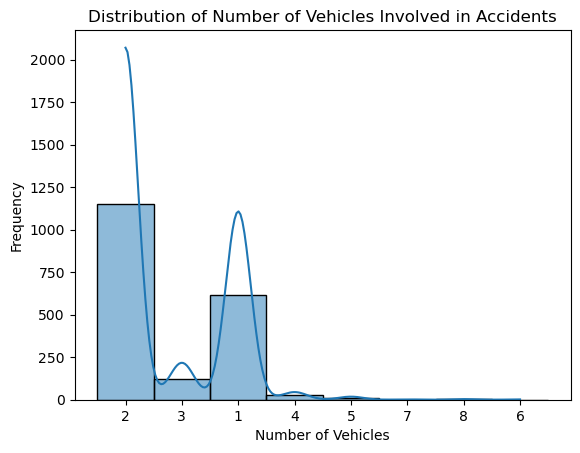

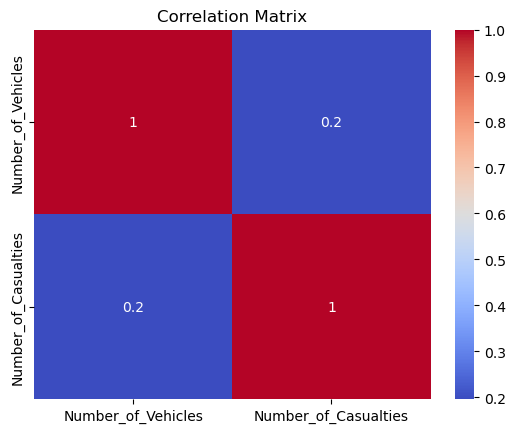

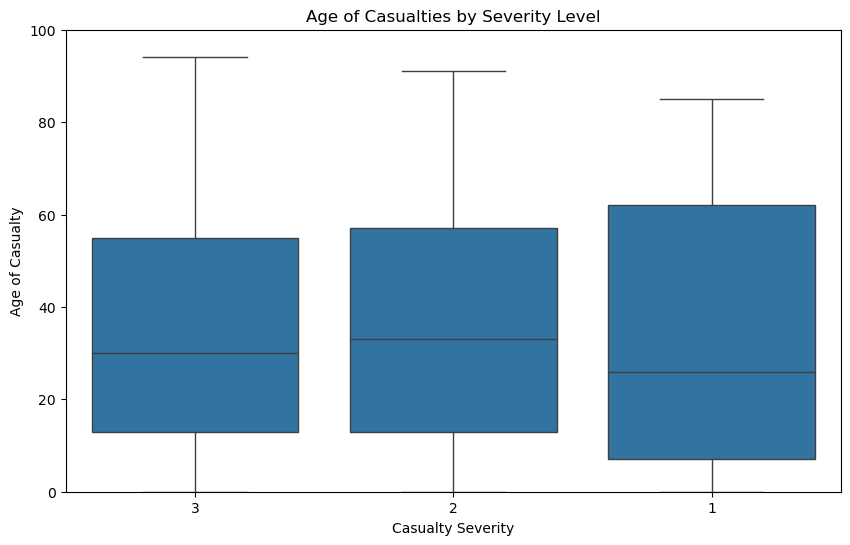

Basic Statistics:
        Vehicles_Scaled  Casualties_Scaled
count     1.930000e+03       1.930000e+03
mean      1.021635e-16      -1.086063e-16
std       1.000259e+00       1.000259e+00
min      -1.127609e+00      -4.107912e-01
25%      -1.127609e+00      -4.107912e-01
50%       2.901664e-01      -4.107912e-01
75%       2.901664e-01      -4.107912e-01
max       8.796816e+00       1.154137e+01


C:\Users\Electronica Care\AppData\Local\Temp\ipykernel_7056\2159638628.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accidents_per_month.index, y=accidents_per_month.values, palette='viridis')


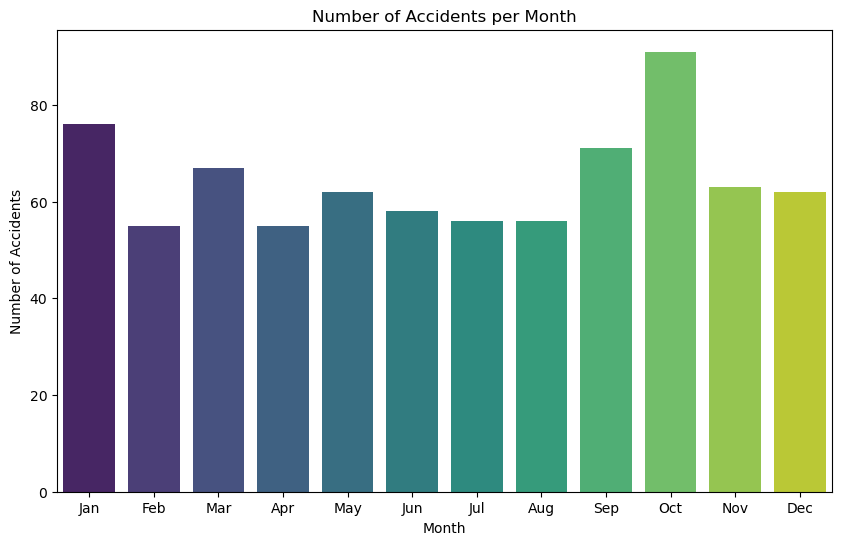

Applying K-Means clustering...

Predicted Data with Damage Extent:
  Number_of_Vehicles Number_of_Casualties  Damage_Extent
0                  2                    1              2
1                  3                    2              8
2                  3                    2              8
3                  2                    1              2
4                  3                    1              8
5                  1                    1              4
6                  1                    1              4
7                  4                    2              1
8                  2                    1              2
9                  1                    1              4
Generating figures for analysis...


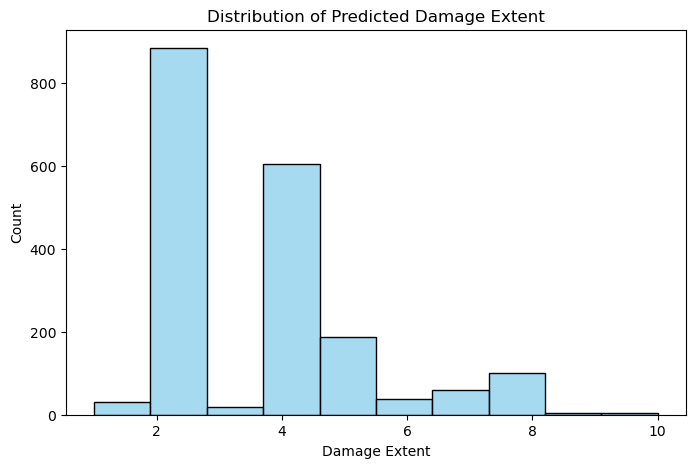

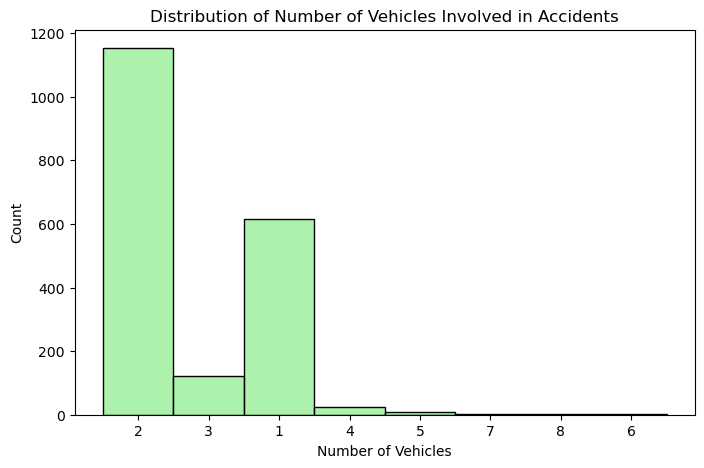

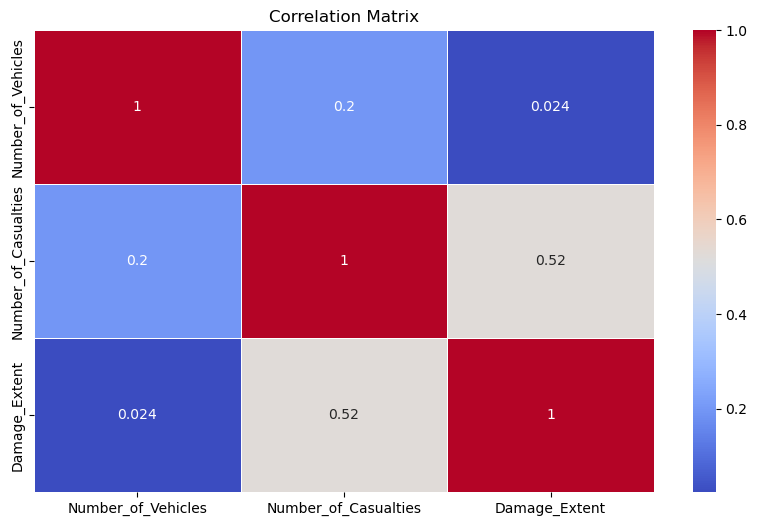

Loading data to accidents_with_damage_extent.csv...
Process completed successfully.


In [17]:
if __name__ == "__main__":
    main()